# CWM1-Steinschlagrisiko
<p>Datum: 13.01.23</p>
<p>Autoren: Logan Henchoz, Noah Recher, Kevin Wartmann, Arian Iseni</p>

## Einleitung


## Systemdefinition

## Lösungsstrategie

### Explorative Datenanalyse

#### Module importieren

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats
import statsmodels.api as sm

#### Daten laden und säubern

In [37]:
def open_csv_to_df(directory):

    # CSV-Datei einlesen
    df = pd.read_csv(directory)

    # Spalten befüllen und neu beschriften
    df = df.iloc[0:,:4]
    df.columns = ["Date", "Time", "Mass_(kg)", "Velocity_(m/s)"]

    # Nach Datum sortieren
    df = df.sort_values(['Date', 'Time']).reset_index(drop=True)

    # NAs löschen
    df = df.dropna()

    # Datum und Zeit in einer Spalte zusammenfügen
    for i in range(len(df)):
        date_raw = df.iloc[i,:].Date + " " +df.iloc[i,:].Time
        date1 = datetime.strptime(date_raw, '%Y-%m-%d %H:%M')
        df.iloc[i,0] = date1

    # Zeit-Spalten bereinigen
    df.rename(columns = {'Date':'Datetime'}, inplace=True)

    return df

In [38]:
df_area1 = open_csv_to_df("./out_1.csv")
df_area1

,Datetime,Time,Mass_(kg),Velocity_(m/s)
0,2019-01-01 09:00:00,09:00,194.0,8.4
1,2019-01-01 21:00:00,21:00,224.0,8.8
2,2019-01-02 14:00:00,14:00,3104.0,9.2
3,2019-01-04 15:00:00,15:00,228.0,8.0
4,2019-01-05 23:00:00,23:00,755.0,7.0
...,...,...,...,...
63,2019-03-18 16:00:00,16:00,167.0,8.9
64,2019-03-22 18:00:00,18:00,2847.0,7.0
65,2019-03-26 00:00:00,00:00,44.0,8.9
66,2019-03-26 06:00:00,06:00,45.0,8.4


In [39]:
df_area2 = open_csv_to_df("./out_2.csv")
df_area2

,Datetime,Time,Mass_(kg),Velocity_(m/s)
0,2019-01-01 09:00:00,09:00,38.0,45.4
1,2019-01-03 06:00:00,06:00,187.0,41.6
2,2019-01-04 10:00:00,10:00,36.0,44.6
3,2019-01-07 14:00:00,14:00,6.0,41.2
4,2019-01-11 06:00:00,06:00,65.0,39.6
5,2019-01-11 16:00:00,16:00,58.0,33.2
6,2019-01-14 11:00:00,11:00,365.0,40.2
7,2019-01-16 02:00:00,02:00,22.0,46.5
8,2019-01-18 06:00:00,06:00,146.0,36.2
9,2019-01-19 17:00:00,17:00,29.0,38.3


#### Zeitabstände berechnen

In [40]:
def calc_time_delta(df):

    # Neue Spalte erstellen
    df.insert(3, "Time_delta_(h)", "")

    # Zeitabstand berechnen
    for i in range(len(df)-1):
        date1 = df.iloc[i,0]
        date2 = df.iloc[i+1,0]
        time_delta = date2 - date1
        time_delta = (time_delta.days*24) + (time_delta.seconds//3600)
        df.iloc[i+1,3] = time_delta

    # Erster Eintrag mit Null ersetzen
    df.iloc[0,3] = 0

    # Datentyp zu Integer ändern
    df['Time_delta_(h)'] = df['Time_delta_(h)'].astype('int')

    return df

In [41]:
df_area1 = calc_time_delta(df_area1)
df_area1

,Datetime,Time,Mass_(kg),Time_delta_(h),Velocity_(m/s)
0,2019-01-01 09:00:00,09:00,194.0,0,8.4
1,2019-01-01 21:00:00,21:00,224.0,12,8.8
2,2019-01-02 14:00:00,14:00,3104.0,17,9.2
3,2019-01-04 15:00:00,15:00,228.0,49,8.0
4,2019-01-05 23:00:00,23:00,755.0,32,7.0
...,...,...,...,...,...
63,2019-03-18 16:00:00,16:00,167.0,28,8.9
64,2019-03-22 18:00:00,18:00,2847.0,98,7.0
65,2019-03-26 00:00:00,00:00,44.0,78,8.9
66,2019-03-26 06:00:00,06:00,45.0,6,8.4


In [42]:
df_area2 = calc_time_delta(df_area2)
df_area2

,Datetime,Time,Mass_(kg),Time_delta_(h),Velocity_(m/s)
0,2019-01-01 09:00:00,09:00,38.0,0,45.4
1,2019-01-03 06:00:00,06:00,187.0,45,41.6
2,2019-01-04 10:00:00,10:00,36.0,28,44.6
3,2019-01-07 14:00:00,14:00,6.0,76,41.2
4,2019-01-11 06:00:00,06:00,65.0,88,39.6
5,2019-01-11 16:00:00,16:00,58.0,10,33.2
6,2019-01-14 11:00:00,11:00,365.0,67,40.2
7,2019-01-16 02:00:00,02:00,22.0,39,46.5
8,2019-01-18 06:00:00,06:00,146.0,52,36.2
9,2019-01-19 17:00:00,17:00,29.0,35,38.3


#### Vergleich der beiden Zonen

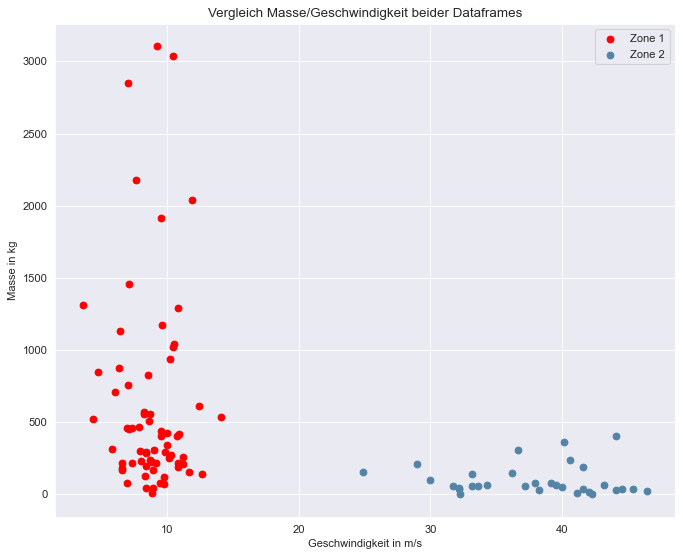

In [43]:
plt.figure(figsize=(10, 8), dpi=80)
plt.title("Vergleich Masse/Geschwindigkeit beider Dataframes")
plt.xlabel("Geschwindigkeit in m/s")
plt.ylabel("Masse in kg")
plt.scatter(x = df_area1["Velocity_(m/s)"],y = df_area1["Mass_(kg)"], color = "red", label = "Zone 1")
plt.scatter(x = df_area2["Velocity_(m/s)"],y = df_area2["Mass_(kg)"], color = '#5384A6', label = "Zone 2")
plt.legend(loc='upper right')
plt.show()

#### Abhängigkeit von Tageszeit und Steinschlag

In [44]:
def plot_incidents_over_time(df, zone):
    plt.hist(df["Time"], color='#5384A6', bins = 20)
    plt.xticks(rotation=90)
    plt.xlabel("Uhrzeit")
    plt.ylabel("Anzahl")
    plt.title("Verteilung der Steinschläge nach Uhrzeit in {}".format(zone))
    plt.show()

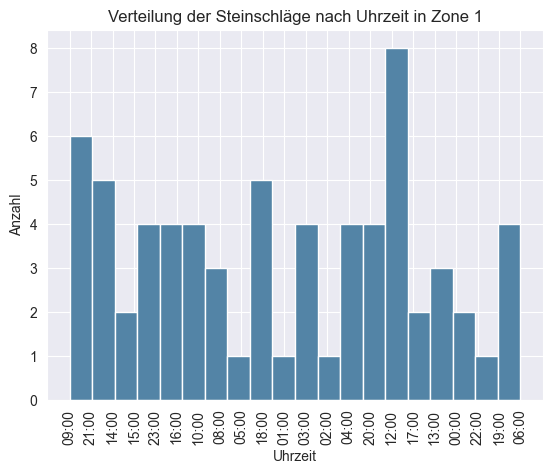

In [45]:
plot_incidents_over_time(df_area1, "Zone 1")

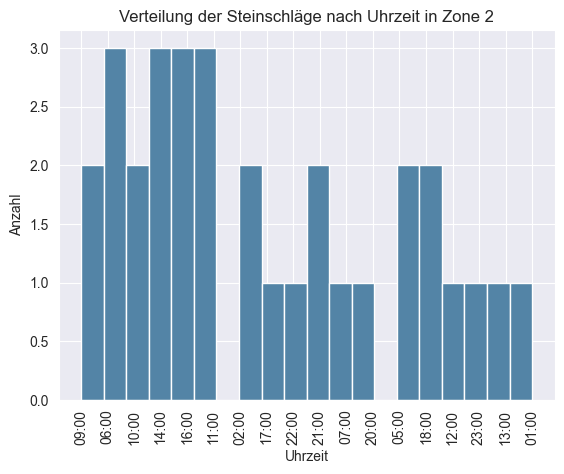

In [46]:
plot_incidents_over_time(df_area2, "Zone 2")

#### Visualisierung der Verteilung von Zufallsvariablen

In [47]:
# Histrogramm erstellen
def plot_histogram(data):
    plt.hist(data, bins=30, color='#5384A6')
    plt.xlim([data.min(), data.max()])
    plt.xlabel(data.head().name)
    plt.ylabel('Anzahl')
    plt.title('Histrogramm von ' + data.head().name)

##### Zone 1

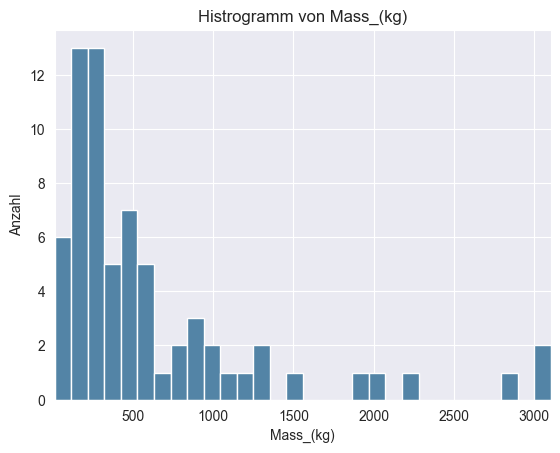

In [48]:
plot_histogram(df_area1["Mass_(kg)"])

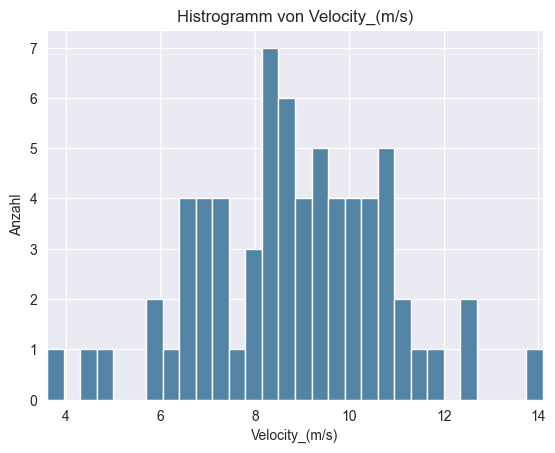

In [49]:
plot_histogram(df_area1["Velocity_(m/s)"])

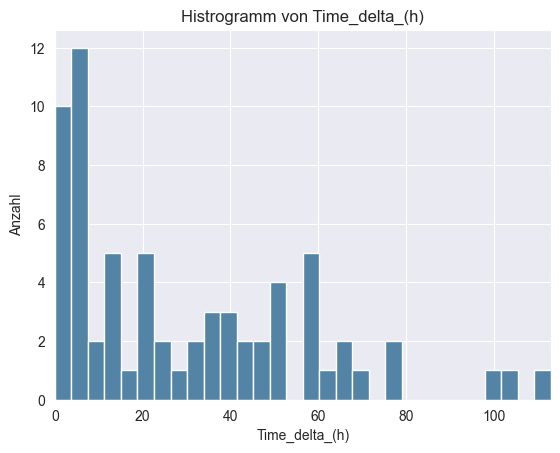

In [50]:
plot_histogram(df_area1["Time_delta_(h)"])

##### Zone 2

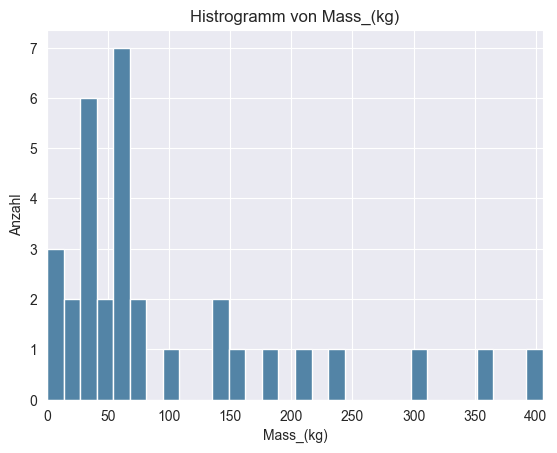

In [51]:
plot_histogram(df_area2["Mass_(kg)"])

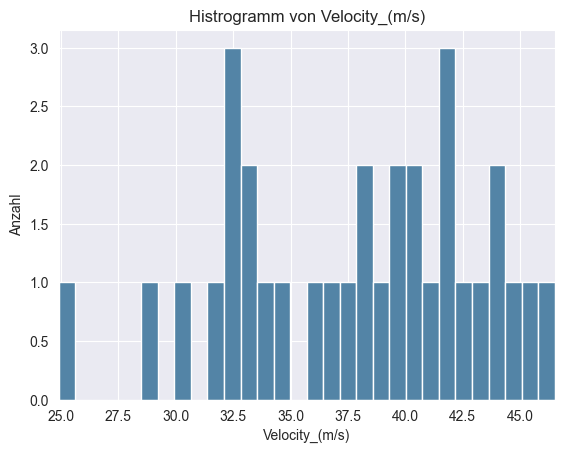

In [52]:
plot_histogram(df_area2["Velocity_(m/s)"])

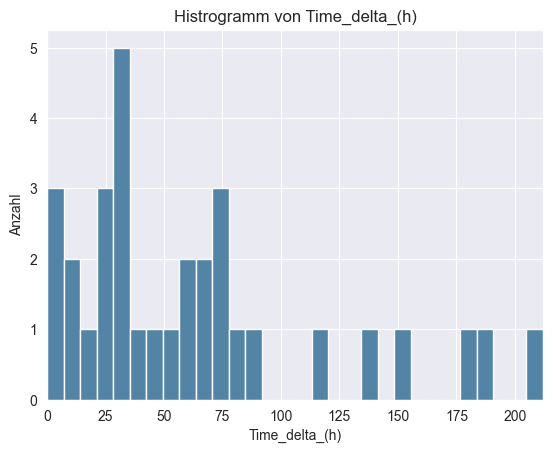

In [53]:
plot_histogram(df_area2["Time_delta_(h)"])

### Verteilungsfunktionen bestimmen

In [54]:
def fit(data):
    # Verteilungsfunktionen definieren
    distributions = ['norm', 'expon', 'lognorm','gamma', 'cauchy']

    # Werte gleichmässig auf X-Achse verteilen
    x = np.linspace(min(data), max(data), 1_000)

    # ECDF von den definierten Verteilungsfunktionen erstellen
    for distribution in distributions:
        param = eval('stats.' + distribution + '.fit(data)')
        sample = eval('stats.' + distribution + '.cdf(x, *param)')
        plt.plot(x, sample)

    # ECDF ploten
    plt.hist(data, cumulative=True, density=True, bins=200, color='#5384A6')
    plt.xlim([data.min(), data.max()])
    plt.xlabel(data.head().name)
    plt.ylabel('F(x)')
    plt.legend(distributions, loc='lower right')
    plt.title('Empirische kumulative Verteilungsfunktion von ' + data.head().name)

    # QQ-Plots für die Verteilungsfunktionen erstellen und ploten
    count = 0
    fig, ax = plt.subplots(1, len(distributions), figsize=(25, 5))
    fig.suptitle('Quantil-Quantil Plots der angepassten Verteilungsfunktionen und ' + data.head().name, fontsize=16)

    for distribution in distributions:
        param = eval('stats.' + distribution + '.fit(data)')
        sample = eval('stats.' + distribution + '.rvs(*param, size = 10000)')
        sm.qqplot_2samples(data, sample, xlabel=distribution.capitalize() + ' Verteilung', ylabel='Probe Verteilung', line='45', ax=ax[count])
        count += 1

#### Zone 1
##### Masse

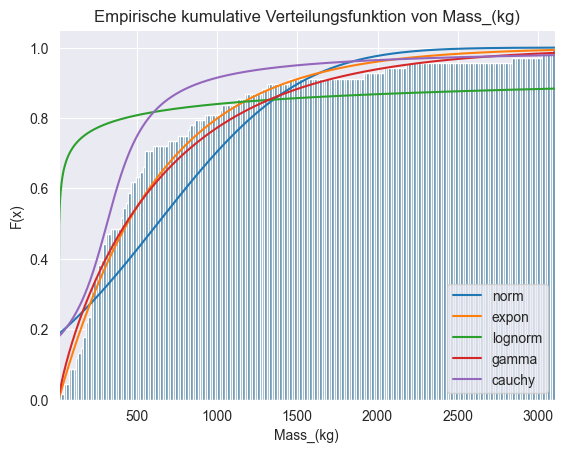

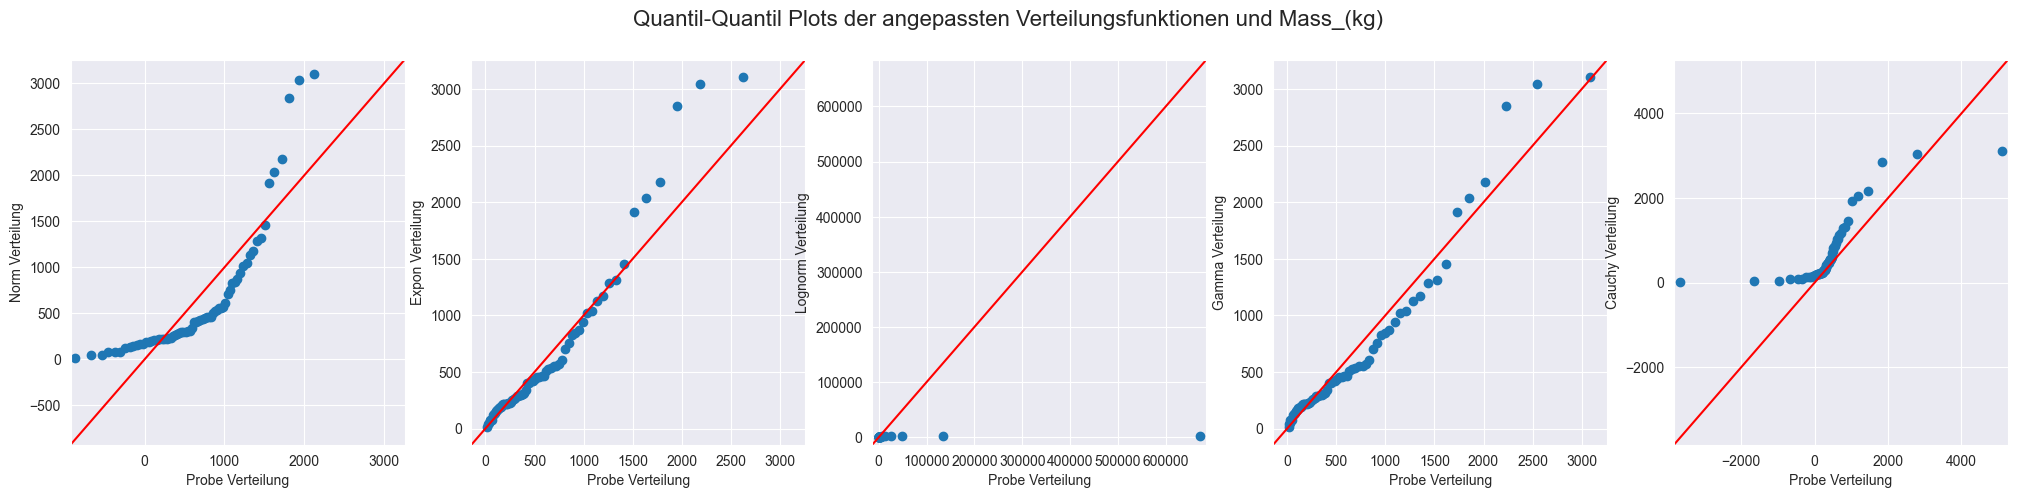

In [55]:
fit(df_area1['Mass_(kg)'])

##### Geschwindigkeit

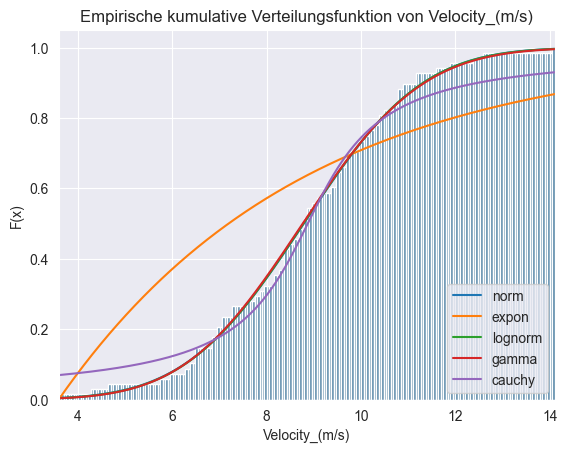

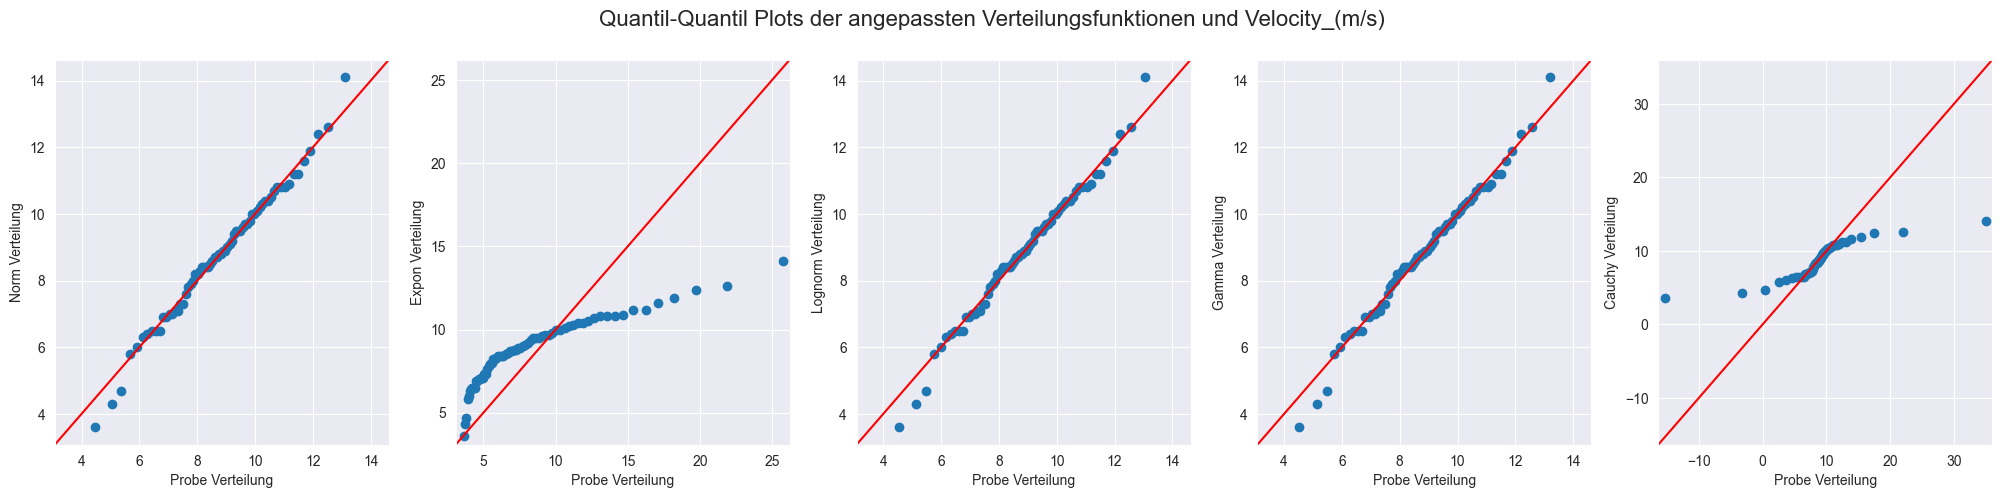

In [56]:
fit(df_area1["Velocity_(m/s)"])

##### Zeitabstand

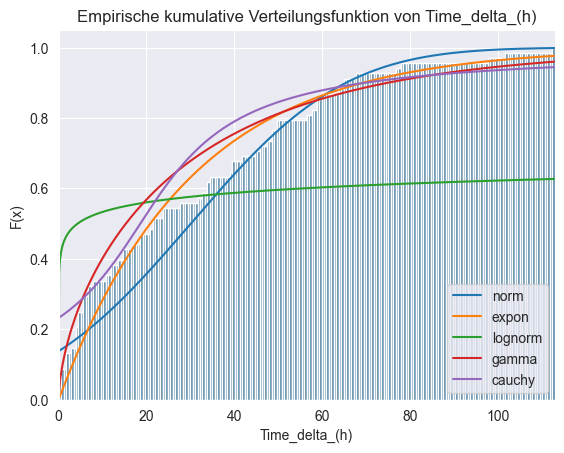

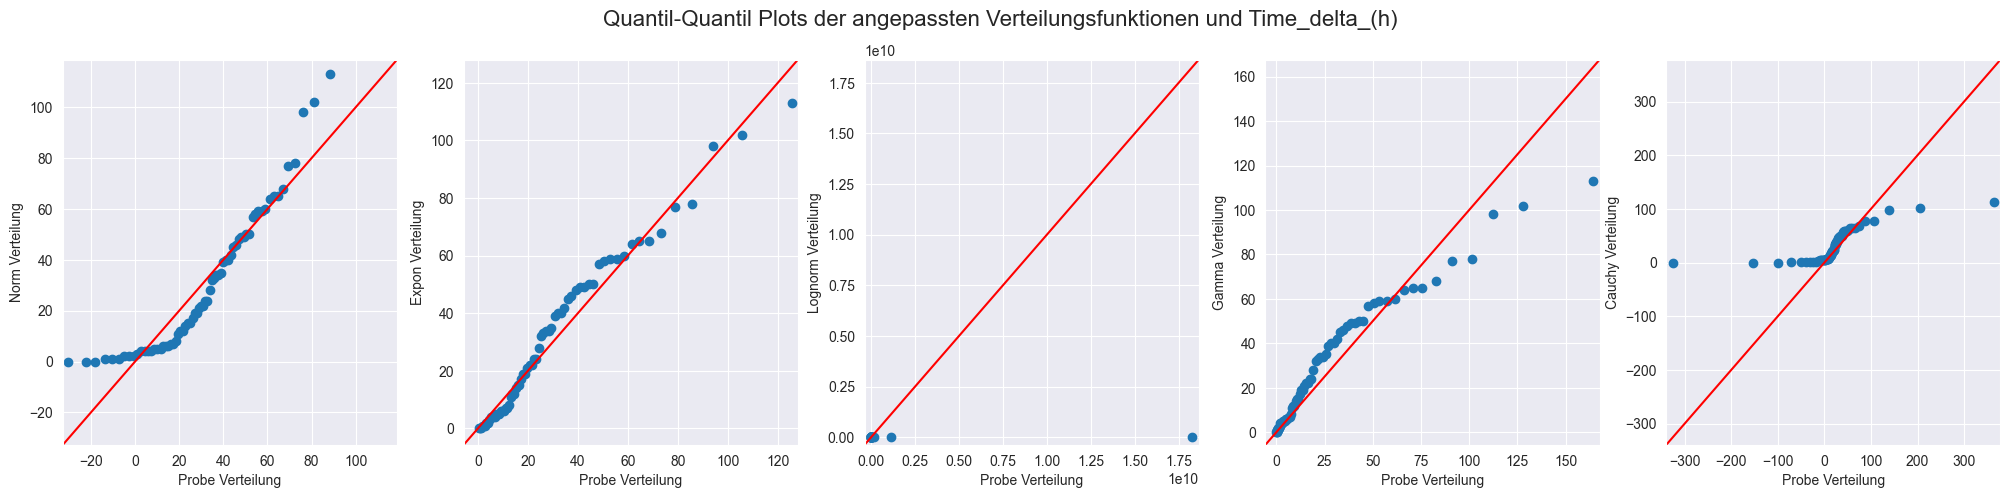

In [57]:
fit(df_area1["Time_delta_(h)"])

#### Zone 2
##### Masse

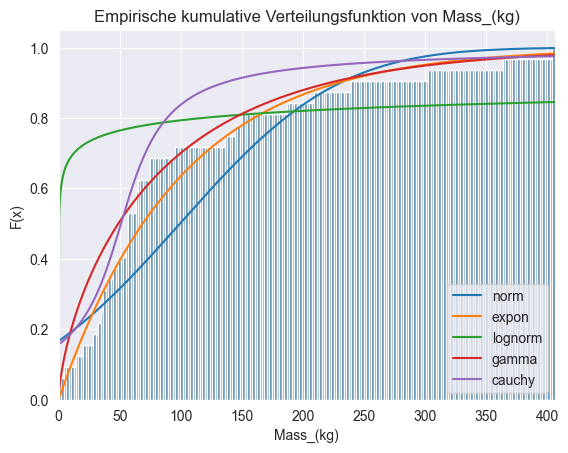

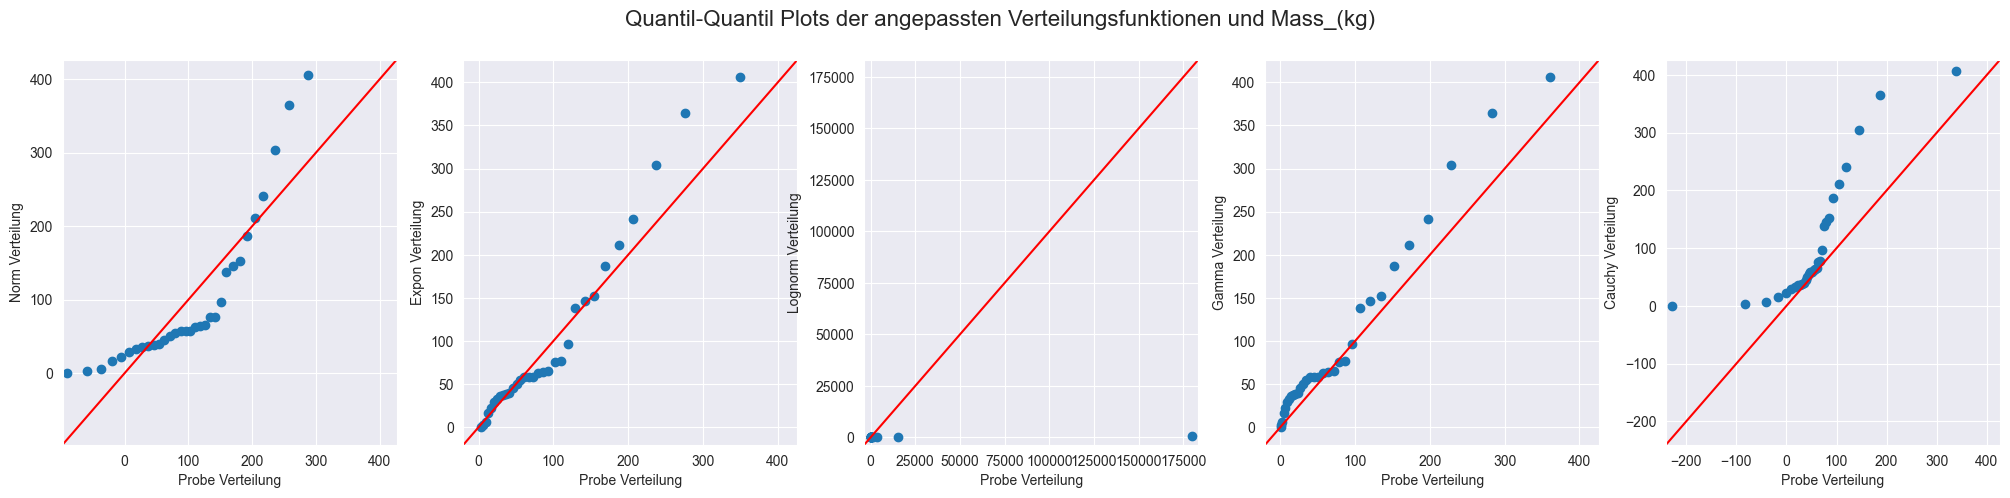

In [58]:
fit(df_area2['Mass_(kg)'])

##### Geschwindigkeit

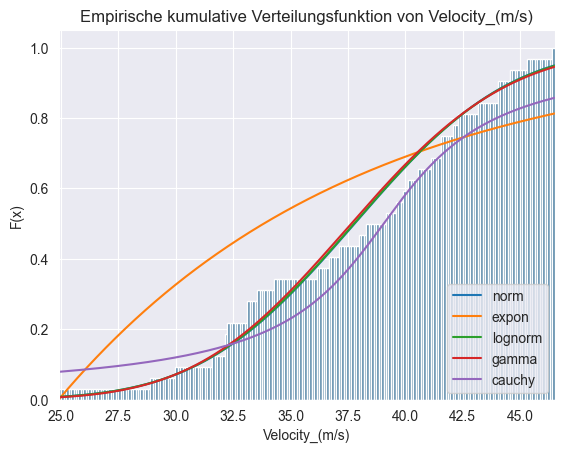

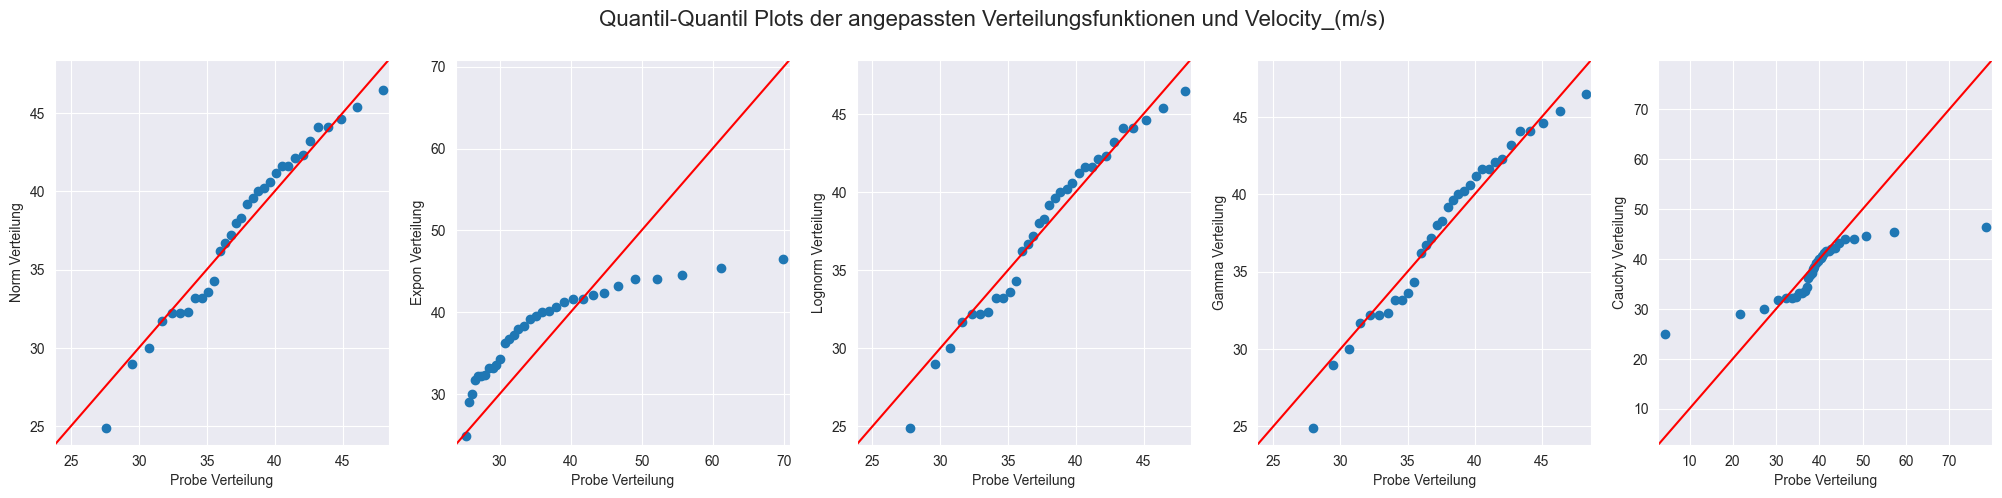

In [59]:
fit(df_area2["Velocity_(m/s)"])

##### Zeitabstand

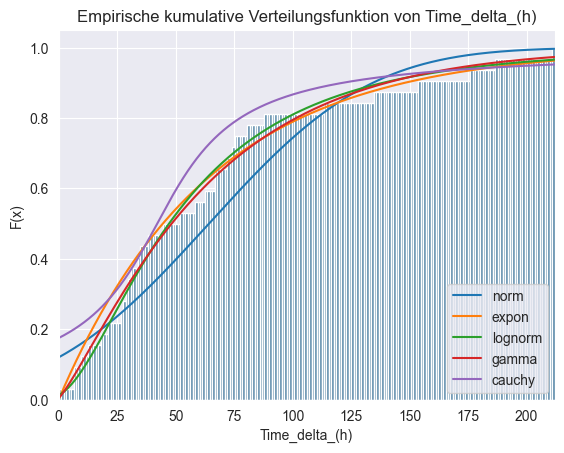

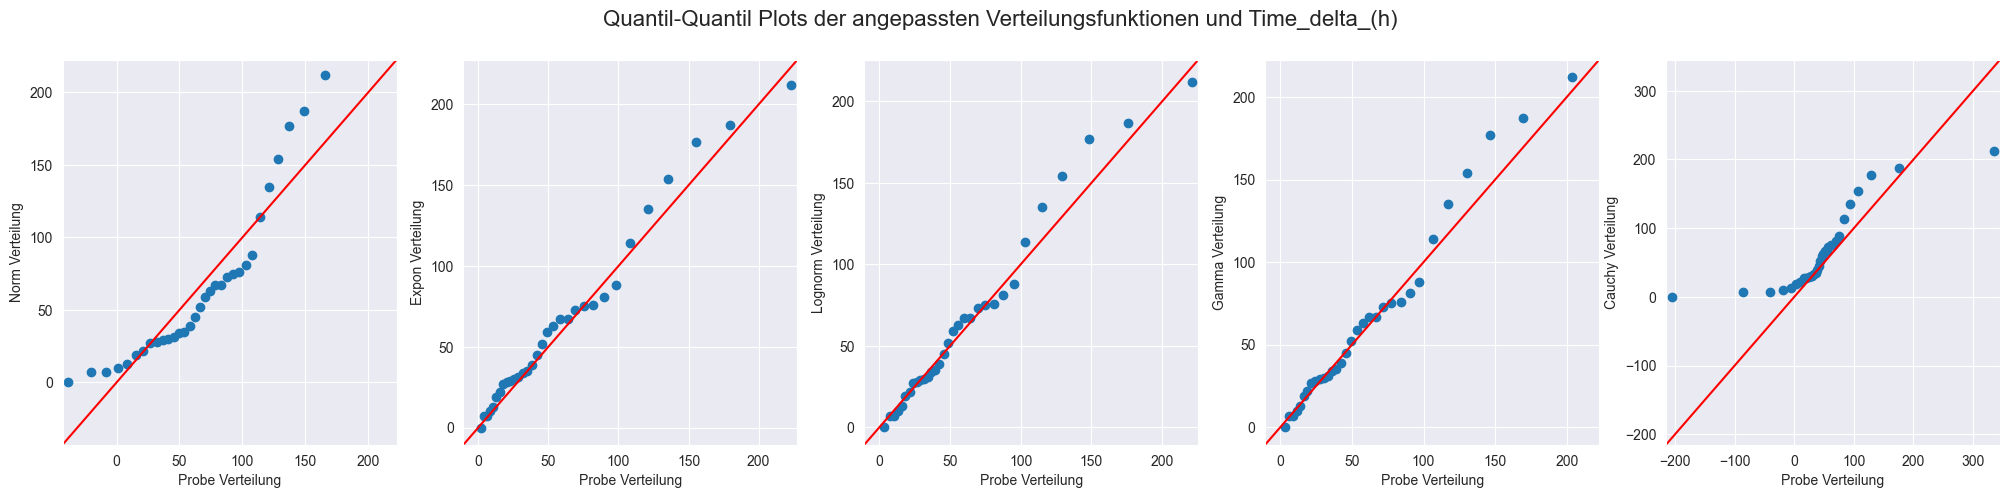

In [60]:
fit(df_area2["Time_delta_(h)"])

## Wahrscheinlichkeitsmodell

### Monte Carlo Simulation

In [61]:
# Anzahl Simulationen
sim_count = 1_000_000

#### Zone 1

In [62]:
# Masse
param = stats.gamma.fit(df_area1['Mass_(kg)'])
zone1_mass = stats.gamma.rvs(*param, size = sim_count)

# Geschwindigkeit
param = stats.norm.fit(df_area1["Velocity_(m/s)"])
zone1_velocity = stats.norm.rvs(*param, size = sim_count)

# Zeitabstand
param = stats.expon.fit(df_area1["Time_delta_(h)"])
zone1_time_delta = stats.expon.rvs(*param, size = sim_count)

#### Zone 2

In [63]:
# Masse
param = stats.gamma.fit(df_area2['Mass_(kg)'])
zone2_mass = stats.gamma.rvs(*param, size = sim_count)

# Geschwindigkeit
param = stats.norm.fit(df_area2["Velocity_(m/s)"])
zone2_velocity = stats.norm.rvs(*param, size = sim_count)

# Zeitabstand
param = stats.expon.fit(df_area2["Time_delta_(h)"])
zone2_time_delta = stats.expon.rvs(*param, size = sim_count)

### Simulierte Zufallsvariablen zusammenfügen

#### Zone 1

In [64]:
# Dataframe erstellen
df_area1_sim = pd.DataFrame()

# Simulierte Zufallsvariable einfügen
df_area1_sim.insert(0, "Mass_(kg)", zone1_mass)
df_area1_sim.insert(1, "Velocity_(m/s)", zone1_velocity)
df_area1_sim.insert(2, "Energy_(kJ)", "")
df_area1_sim.insert(3, "Time_delta_(h)", zone1_time_delta)

# Energie berechnen
df_area1_sim["Energy_(kJ)"] = (0.5 * df_area1_sim["Mass_(kg)"] * (df_area1_sim["Velocity_(m/s)"] ** 2)) / 1000

# Zeitabstände auf 2 Stellen nach dem Komma runden
df_area1_sim["Time_delta_(h)"] = zone1_time_delta.round(2)

# Erster Eintrag gleich Null setzen
df_area1_sim["Time_delta_(h)"][0] = 0

df_area1_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h)
0,2718.222095,11.219649,171.085599,0.00
1,627.651800,9.933223,30.964861,2.45
2,850.829377,6.792632,19.628571,11.06
3,1834.678396,11.030921,111.622953,27.62
4,1240.943978,8.136416,41.076034,42.92
...,...,...,...,...
999995,164.353860,9.560573,7.511346,10.17
999996,1137.969245,9.955913,56.397869,16.74
999997,452.001462,7.095228,11.377387,53.46
999998,848.377660,5.968250,15.109609,3.74


#### Zone 2

In [65]:
# Dataframe erstellen
df_area2_sim = pd.DataFrame()

# Simulierte Zufallsvariable einfügen
df_area2_sim.insert(0, "Mass_(kg)", zone2_mass)
df_area2_sim.insert(1, "Velocity_(m/s)", zone2_velocity)
df_area2_sim.insert(2, "Energy_(kJ)", "")
df_area2_sim.insert(3, "Time_delta_(h)", zone2_time_delta)

# Energie berechnen
df_area2_sim["Energy_(kJ)"] = (0.5 * df_area2_sim["Mass_(kg)"] * (df_area2_sim["Velocity_(m/s)"] ** 2)) / 1000

# Zeitabstände auf 2 Stellen nach dem Komma runden
df_area2_sim["Time_delta_(h)"] = zone2_time_delta.round(2)

# Erster Eintrag gleich Null setzen
df_area2_sim["Time_delta_(h)"][0] = 0

df_area2_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h)
0,84.445015,43.269206,79.050000,0.00
1,81.908209,34.082927,47.574167,70.17
2,4.763371,32.974086,2.589583,77.46
3,0.089735,35.115882,0.055327,57.43
4,261.627558,33.490386,146.721510,10.76
...,...,...,...,...
999995,452.060118,33.880520,259.457569,27.41
999996,8.576134,36.281826,5.644687,5.54
999997,187.075682,40.740705,155.254582,12.02
999998,135.507793,46.577979,146.992627,45.19


#### Zonen zusammenfügen

In [66]:
df_sim = pd.concat([df_area1_sim,df_area2_sim])
df_sim = df_sim.sample(frac=1,ignore_index=True)

### Berechnung der Netzdurchbrüche
In diesem Abschnitt gehen wir über unsere simulierte Daten und berechnen wieviele Steine aus dem Netz brechen und somit auf die Strasse fallen.

In [67]:
def net_test(net_status, weight_in_net, impact_energy):

    # Wenn das Netz schon gerissen ist fällt der Stein
    if net_status == True:
        return True

    # Wenn mehr als 2000 kg im Netz liegen und die Aufprallenergie grösser als 500 kJ ist reisst das Netz
    elif weight_in_net > 2000:
        if impact_energy > 500:
            return True
        else:
            return False

    # Wenn weniger als 2000 kg im Netz liegen und die Aufprallenergie grösser als 1000 kJ ist reisst das Netz
    elif weight_in_net <= 2000:
        if impact_energy > 1000:
            return True
        else:
            return False

    # Falls nichts zutrifft ist das Netz noch unbeschädigt
    else:
        return False

Für die Berechnung der Incidents müssen wir viel Logik anwenden. Daher sind viele if-Statements notwendig. Wichtig ist hinzuzufügen, dass wir nicht die Unfälle sondern die Anzahl Steine betrachten wollen. Um nicht die Summen wiederholt zu addieren, werden die Summen immer erst im nächsten Slot addiert. Desshalb ist die Abfrage, ob das Netz gerissen ist, am Anfang der neuen Slots gesetzt.


In [77]:
time_interval = 24          # Im 24 Stunden Takt werden die Netze geprüft, entleert und ggf. repariert
current_delta = 0           # Start Zeitabstand setzen
hours_total = 0             # Total Anzahl Stunden, welche wir simulieren
weight_in_net = 0           # Masse welche sich im Netz befindet
net_status = False          # Status ob das Netz gerissen ist (False -> Nein)
incident = 0                # Anzahl Steine, welche auf die Strasse fallen
stones_in_net = 0           # Anzahl Steine, welche sich bereits im Netz befinden
sim_stones = len(df_sim)    # Anzahl simulierte Steine

for i in range(int(sim_stones)):
    iterated_delta = df_sim["Time_delta_(h)"][i]    # Zeit welche nach dem letzten Stein vergangen ist
    iterated_energy = df_sim["Energy_(kJ)"][i]      # Energie des iterierten Elements

    hours_total += iterated_delta  # Bei jedem Durchgang werden die Stunden addiert

    # Wenn der Zeitabstand grösser als 24 Std. ist:
    if (iterated_delta > time_interval):

        # Falls das Netz bereits gerissen ist:
        if net_status:
            incident += stones_in_net

        stones_in_net = 1
        net_status = net_test(False,0,iterated_energy) # Wir testen, ob das Netz in diesem Fall reisst
        weight_in_net = df_sim["Mass_(kg)"][i]

        iterated_delta = iterated_delta % time_interval  # Wir brechen das delta runter, auf alle Stunden welche nach 24 Std. Slots übrig bleiben würden, 36 Std. - 24 Std. = 12 Std. Restzeit

        # --> Wir berechnen die Restzeit, welche übrig bleibt, wenn das Zeitdelta sich mit dem nächsten Slot überschneidet.

        # Falls die Restzeit grösser ist als (24 Std. - current_delta):
        if iterated_delta > (time_interval - current_delta):

            current_delta = abs((time_interval - current_delta)-iterated_delta)


        elif iterated_delta <= (time_interval - current_delta):

            current_delta = current_delta + iterated_delta

    # Falls der Zeitabstand kleiner als 24h ist:
    elif iterated_delta <= time_interval:

        # Falls das iterated_delta grösser ist als (24 Std. - current_delta) -> das iterated delta passt nicht mehr in diesen Slot -> wir müssen dieses Ereignis in einem neuen Slot betrachten.
        if iterated_delta > (time_interval - current_delta):

            # Falls das Netz bereits gerissen ist:
            if net_status:
                incident += stones_in_net

            stones_in_net = 1                                # Anzahl Steine auf 1 setzen wegen neuem Slot
            net_status = net_test(False,0,iterated_energy)   # Netz reparieren
            weight_in_net = df_sim["Mass_(kg)"][i]           # Masse im Netz auf neuen Stein setzen
            current_delta = abs((time_interval - current_delta)-iterated_delta)  # current_delta neu berechnen

        # Falls das iterated_delta in den Slot passt -> Wir bleiben im gleichen Slot wie davor.
        elif iterated_delta <= (time_interval - current_delta):
            stones_in_net += 1
            net_status = net_test(net_status,weight_in_net,iterated_energy)
            weight_in_net += df_sim["Mass_(kg)"][i]
            current_delta = current_delta + iterated_delta



amount_sim_years = hours_total / 8760
stones_per_year = (sim_stones / amount_sim_years)
incident_prob_per_stone = incident/sim_stones
incident_prob_per_year = incident_prob_per_stone * stones_per_year

#### Durch diese Berechnung konnten wir wichtige Kennzahlen für spätere Berechnungen ausrechnen:
Die Anzahl Jahre, welche wir simuliert haben:

In [78]:
amount_sim_years

10766.906835616095

Die durchschnittliche Anzahl Steine, welche pro Jahr simuliert werden:

In [79]:
stones_per_year

185.75437036235465

Die Wahrscheinlichkeit, dass ein Stein an einem Tag durch das Netz bricht:

In [75]:
print('{:f}'.format(incident_prob_per_stone))

0.000097


Die Wahrscheinlichkeit, dass ein Stein in einem Jahr durch das Netz bricht:

In [76]:
incident_prob_per_year

0.017925296739967223

### Berechnung des Verkehrs
Als nächstes mussten wir den Verkehr auf dieser Strasse berechnen. Dafür haben zwei verschiedene Szenarien simuliert:
- Einerseits wenn ein Auto direkt, von oben, vom Stein erfasst wird.
- Andererseits wenn ein Auto nicht die Zeit hat, um rechtzeitig zu reagieren.

Diese zwei Szenarien sind für unsere Berechnungen wichtig, da diese für den Autofahrer das grösste Risiko bieten. Da wir die Tödlichkeit einer Frontalenkollision mit 60 km/h nicht einschätzen können und keine Daten/Quellen zu unserer Verfügung stehen, gehen wir vom worst-case aus.

#### Berechnung der Kollision von oben:
Mit der danger_zone methode berechnen wir, die Wahrscheinlichkeit, dass sich an einem Fixpunkt (Ort des Aufschlagens der Steine) ein Auto befindet. Und zwar während eines Jahres.
Dazu wird die Methode mit einer eingegebenen Geschwindigkeit (in km/h), einer Autolänge, der Anzahl Autos pro Tag ausgeführt. Somit können wir die Variabeln schnell ändern und deren Auswirkungen besser untersuchen.

In [90]:
def danger_zone(v_km_h,laenge_auto,autos_pro_tag):
    seconds_per_year = 86400 * 365    # Totale Sekunden in einem Jahr
    v_m_s = (v_km_h / 3.6)
    danger_time_pro_auto = (laenge_auto / v_m_s)    # Zeit, welche die Fläche eines Auto benötigt, um den Punkt vollständig zu überqueren.
    autos_pro_jahr = autos_pro_tag * 365
    danger_time_total = danger_time_pro_auto * autos_pro_jahr     # Totale Zeit der Autoflächen pro Jahr
    danger_prob = (danger_time_total / seconds_per_year)          # Wahrscheinlichkeit, dass sich ein Auto am Punkt befindet.

    return danger_prob

In [91]:
danger_strecke = danger_zone(60,4.4,1200)

#### Berechnung der Frontalenkollision:

In [83]:
def danger_zone_react(v_km_h,laenge_auto,autos_pro_tag):
    seconds_per_year = 86400 * 365
    v_m_s = (v_km_h / 3.6)
    danger_time_pro_auto = 1.5
    autos_pro_jahr = autos_pro_tag * 365
    print(danger_time_pro_auto)
    danger_time_total = danger_time_pro_auto * autos_pro_jahr
    print(danger_time_total)
    danger_percentage = (danger_time_total / seconds_per_year)
    print(danger_percentage)

    return danger_percentage

In [86]:
danger_strecke_react = danger_zone_react(60,4.4,1200)

1.5
657000.0
0.020833333333333332


## Ergebnis

In [92]:
print(incident_prob_per_year)
print(danger_strecke)
print('{:f}'.format(incident_prob_per_year * (danger_strecke + danger_strecke_react)))

0.017925296739967223
0.0036666666666666666
0.000439
